In [1]:
from abc import ABC
from pathlib import Path
from timeit import repeat

import matplotlib.pyplot as plt
import pandas as pd

from codetf.models import load_model_pipeline
from transformers import AutoTokenizer, AutoModelWithLMHead, SummarizationPipeline
from scipy import stats

/home/paul/.conda/envs/codetf/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline

In [3]:
root_dir = Path.cwd()

In [4]:
class AbstractModel(ABC):
    def predict(self) -> str:
        raise NotImplementedError()
    
    def model_name(self) -> str:
        raise NotImplementedError()


class CodeTFModel(AbstractModel):
    def __init__(self, model_name: str, model_type: str, task: str) -> None:
        super().__init__()

        self._model = load_model_pipeline(model_name=model_name, model_type=model_type, task=task)
        self._model_name = model_name
        self._model_type = model_type
        self._task = task

    def predict(self) -> str:
        return self._model.predict(['def hello(): print("Hello world")'])
    
    def model_name(self) -> str:
        return f"{self._model_name}-{self._model_type}-{self._task}"


class SebisModel(AbstractModel):
    def __init__(self, model_name: str) -> None:
        super().__init__()

        self._pipeline = SummarizationPipeline(
            model=AutoModelWithLMHead.from_pretrained(model_name),
            tokenizer=AutoTokenizer.from_pretrained(model_name, skip_special_tokens=True),
            device=0
        )
        self._model_name = model_name

    def predict(self) -> str:
        return self._pipeline(['ef hello(): print("Hello world")'])[0]["summary_text"]
    
    def model_name(self) -> str:
        return self._model_name.replace("/", "-")


class CodeT5PModel(AbstractModel):
    def __init__(self) -> None:
        super().__init__()

        self._pipeline = SummarizationPipeline(
            model=AutoModelWithLMHead.from_pretrained(root_dir.parent / "modeling" / "models" / "codet5p_220m"),
            tokenizer=AutoTokenizer.from_pretrained("Salesforce/codet5p-220m"),
            device=0
        )
        self._model_name = "codet5p_220m"

    def predict(self) -> str:
        return self._pipeline(['def hello(): print("Hello world")'])[0]["summary_text"]
    
    def model_name(self) -> str:
        return self._model_name.replace("/", "-")

In [5]:
def get_runtime(model: AbstractModel):   
    file_path = root_dir / "data" / "runtime" / f"{model.model_name()}.csv"

    if file_path.exists():
        return
    
    #warm up
    model.predict()

    def _predict():
        model.predict()

    with file_path.open("w") as f:
        f.writelines(f"{n}\n" for n in repeat(_predict, number=1, repeat=100))

# Runtime Messung
Im folgenden wird die Laufzeit der Einzelnen Modelle gemessen.

## CodeT5 Base

In [6]:
get_runtime(CodeTFModel(model_name="codet5", model_type="base-multi-sum", task="pretrained"))

In [7]:
get_runtime(CodeTFModel(model_name="codet5", model_type="base", task="sum_python"))

RuntimeError: Only Tensors of floating point and complex dtype can require gradients

## T5 Small

In [ ]:
get_runtime(SebisModel("SEBIS/code_trans_t5_small_code_documentation_generation_python"))

/anaconda/envs/codetf/lib/python3.10/site-packages/transformers/models/auto/modeling_auto.py:1400: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [ ]:
get_runtime(SebisModel("SEBIS/code_trans_t5_small_code_documentation_generation_python_transfer_learning_finetune"))

In [ ]:
get_runtime(SebisModel("SEBIS/code_trans_t5_small_code_documentation_generation_python_multitask"))

In [ ]:
get_runtime(SebisModel("SEBIS/code_trans_t5_small_code_documentation_generation_python_multitask_finetune"))

## T5 Base

In [ ]:
get_runtime(SebisModel("SEBIS/code_trans_t5_base_code_documentation_generation_python"))

In [ ]:
get_runtime(SebisModel("SEBIS/code_trans_t5_base_code_documentation_generation_python_transfer_learning_finetune"))

In [ ]:
get_runtime(SebisModel("SEBIS/code_trans_t5_base_code_documentation_generation_python_multitask"))

In [ ]:
get_runtime(SebisModel("SEBIS/code_trans_t5_base_code_documentation_generation_python_multitask_finetune"))

## T5 Large

In [ ]:
get_runtime(SebisModel("SEBIS/code_trans_t5_large_code_documentation_generation_python_transfer_learning_finetune"))

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 11.17 GiB total capacity; 2.27 GiB already allocated; 7.25 MiB free; 2.34 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
get_runtime(SebisModel("SEBIS/code_trans_t5_large_code_documentation_generation_python_multitask"))

In [ ]:
get_runtime(SebisModel("SEBIS/code_trans_t5_large_code_documentation_generation_python_multitask_finetune"))

## Fine Tuned Model

In [ ]:
get_runtime(CodeT5PModel())

/anaconda/envs/codetf/lib/python3.10/site-packages/transformers/models/auto/modeling_auto.py:1400: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
Your max_length is set to 20, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 20, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 20, but your input_length is only 10. Since this is a summarization task, where outputs shorte

# Statistik
## Normalverteilungstest
Zuerst wird überprüft ob die Stichproben Normalverteilt sind für die Wahl der weiteren Tests

In [ ]:
def test_norm(values: list) -> None:
    """ Testet eine Stichprobe auf Normalverteilung """
    k2, p = stats.normaltest(values)
    if p < 1e-3: # null hypothesis: values comes from a normal distribution
        return f"The null hypothesis can be rejected (p={p})"
    return f"The null hypothesis cannot be rejected (p={p})"

In [4]:
def get_data():
    return sorted(
        (root_dir / "data" / "runtime").glob("*.csv"),
        key=lambda f: f.name
    )

In [ ]:
for csv_file in get_data():
    df = pd.read_csv(csv_file, names=["runtime"])
    print(test_norm(df), "for", csv_file.name)   

The null hypothesis can be rejected (p=[4.29504647e-07]) for SEBIS-code_trans_t5_base_code_documentation_generation_python.csv
The null hypothesis can be rejected (p=[5.93875808e-19]) for SEBIS-code_trans_t5_base_code_documentation_generation_python_multitask.csv
The null hypothesis can be rejected (p=[9.92550268e-10]) for SEBIS-code_trans_t5_base_code_documentation_generation_python_multitask_finetune.csv
The null hypothesis can be rejected (p=[1.13547334e-11]) for SEBIS-code_trans_t5_base_code_documentation_generation_python_transfer_learning_finetune.csv
The null hypothesis can be rejected (p=[1.36167625e-05]) for SEBIS-code_trans_t5_large_code_documentation_generation_python_multitask.csv
The null hypothesis can be rejected (p=[2.36771442e-19]) for SEBIS-code_trans_t5_large_code_documentation_generation_python_multitask_finetune.csv
The null hypothesis can be rejected (p=[7.01545193e-21]) for SEBIS-code_trans_t5_large_code_documentation_generation_python_transfer_learning_finetune.

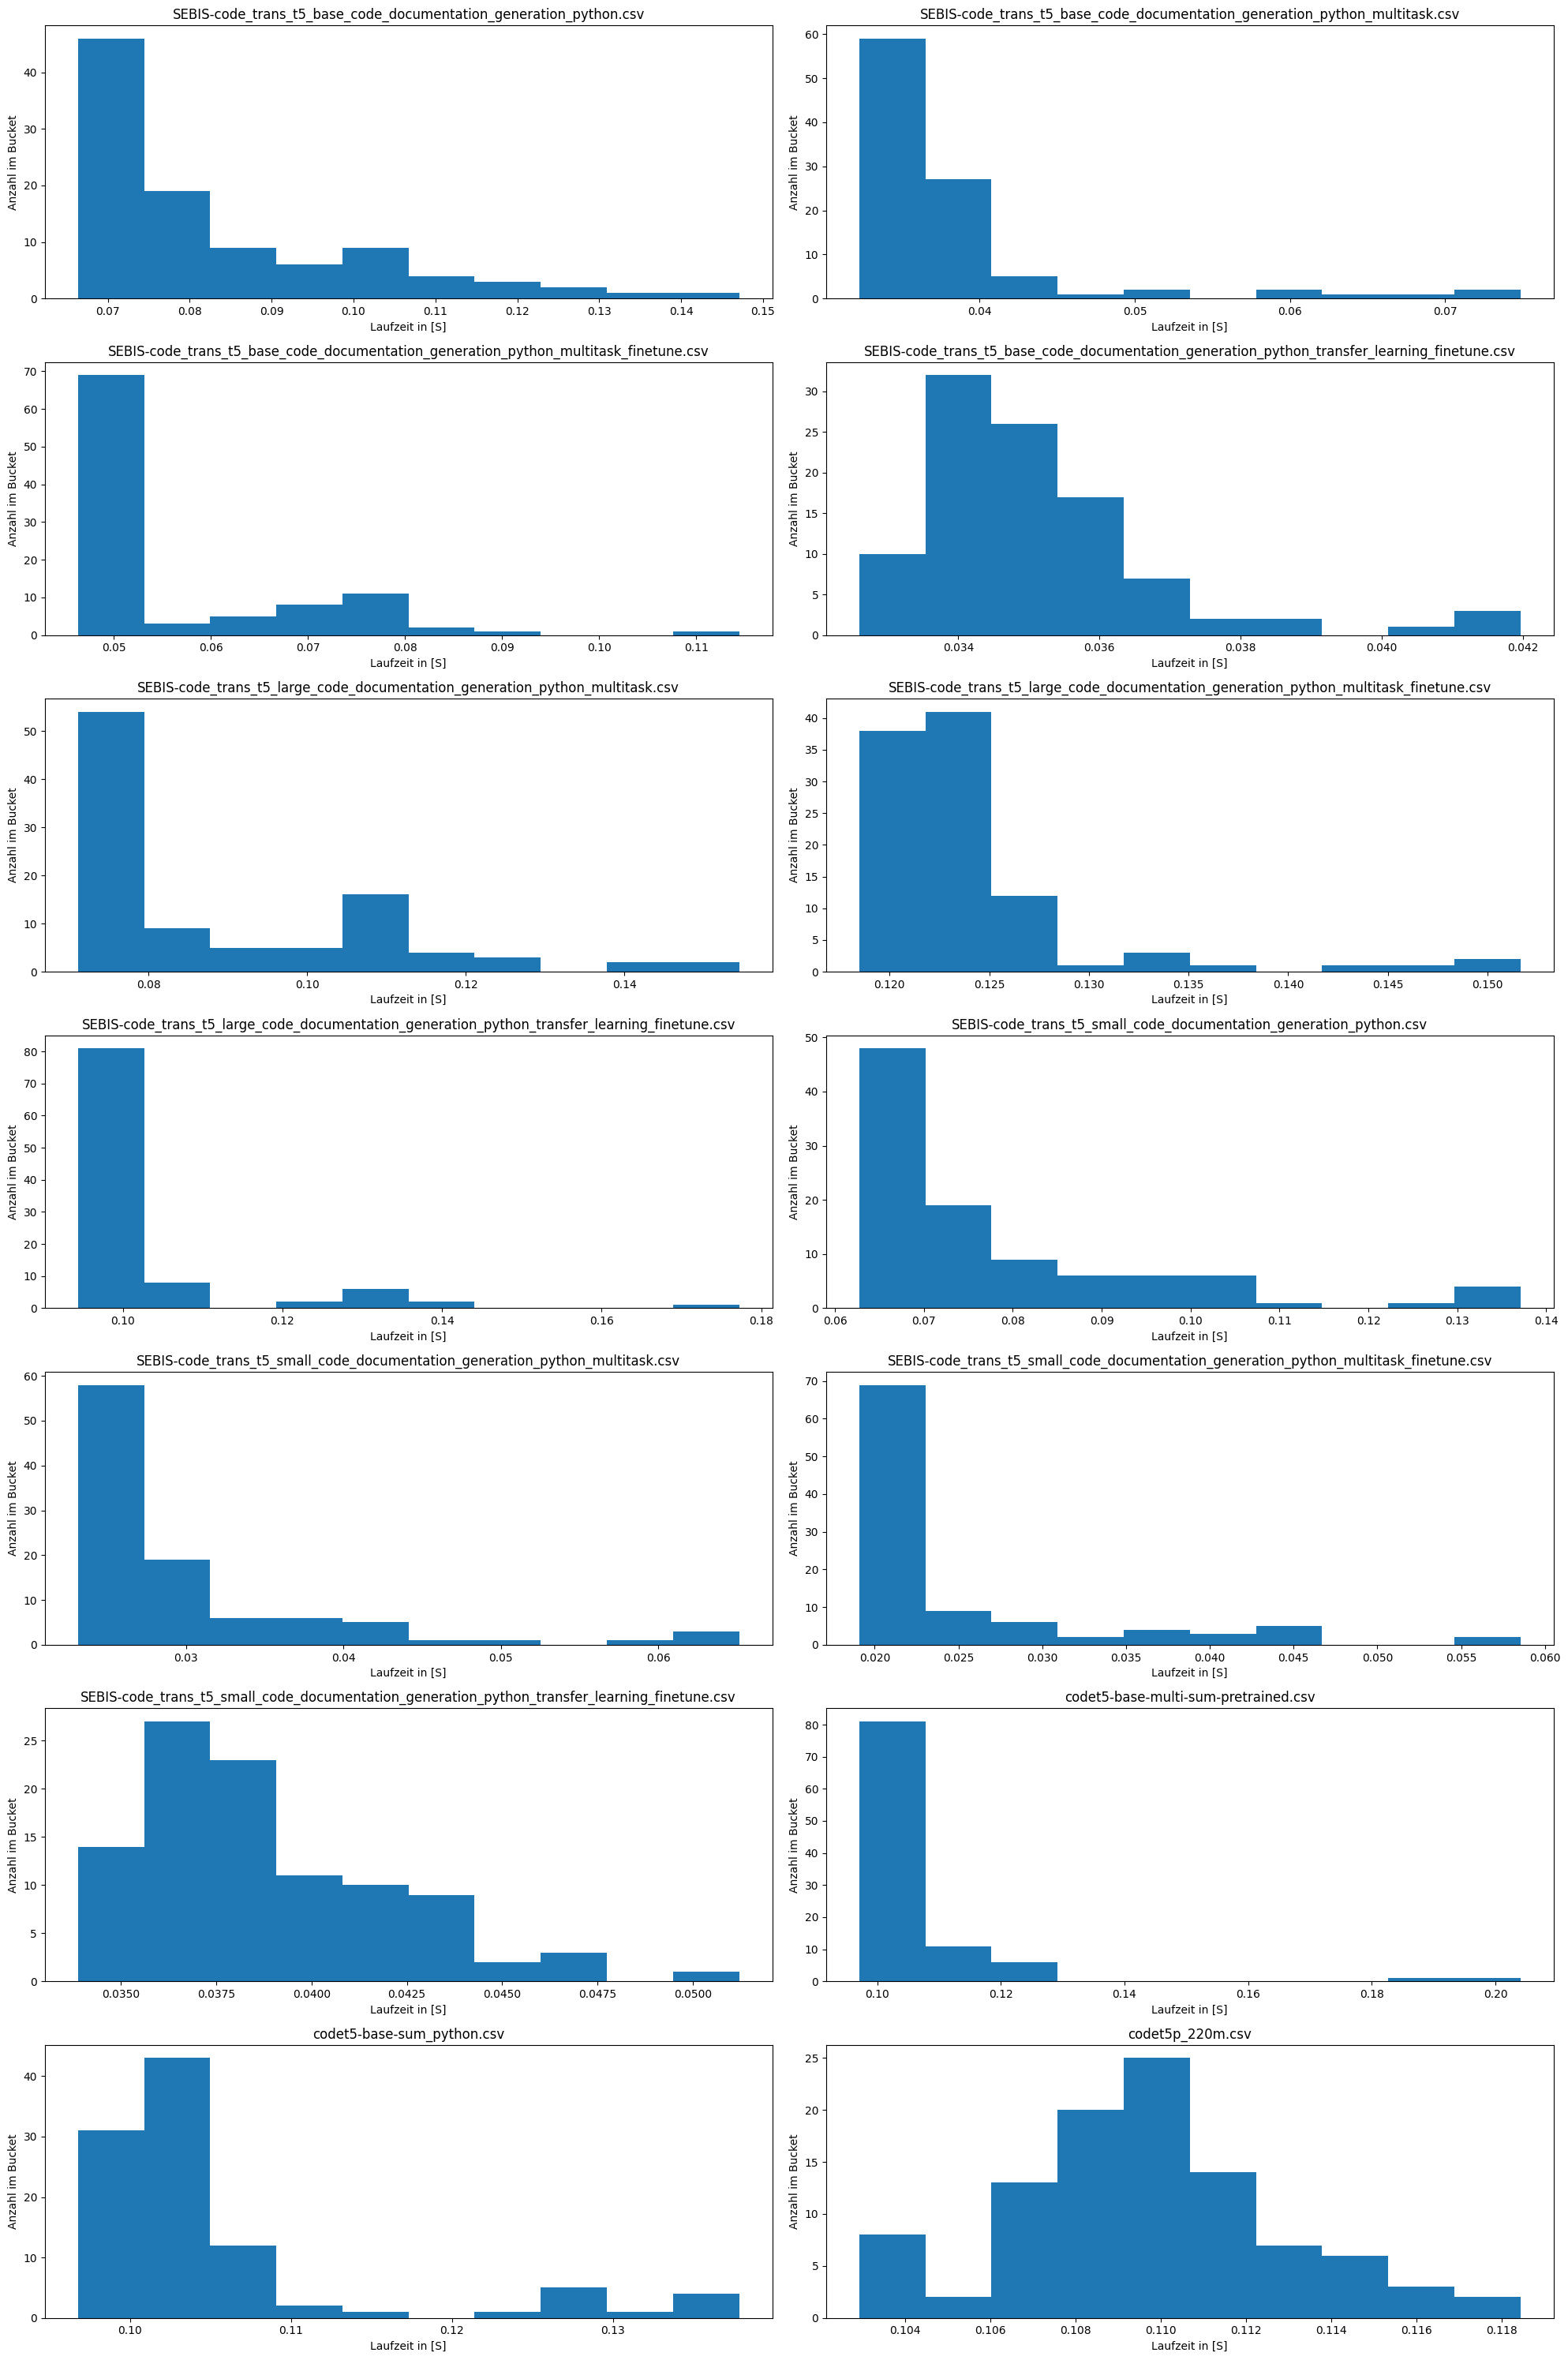

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=7, figsize=(20, 30))

for i, csv_file in enumerate(get_data()):
    df = pd.read_csv(csv_file, names=["runtime"])
    axes[i // 2][i % 2].hist(df)
    axes[i // 2][i % 2].set(
        title=csv_file.name,
        ylabel="Anzahl im Bucket",
        xlabel="Laufzeit in [S]"
    )
plt.tight_layout()

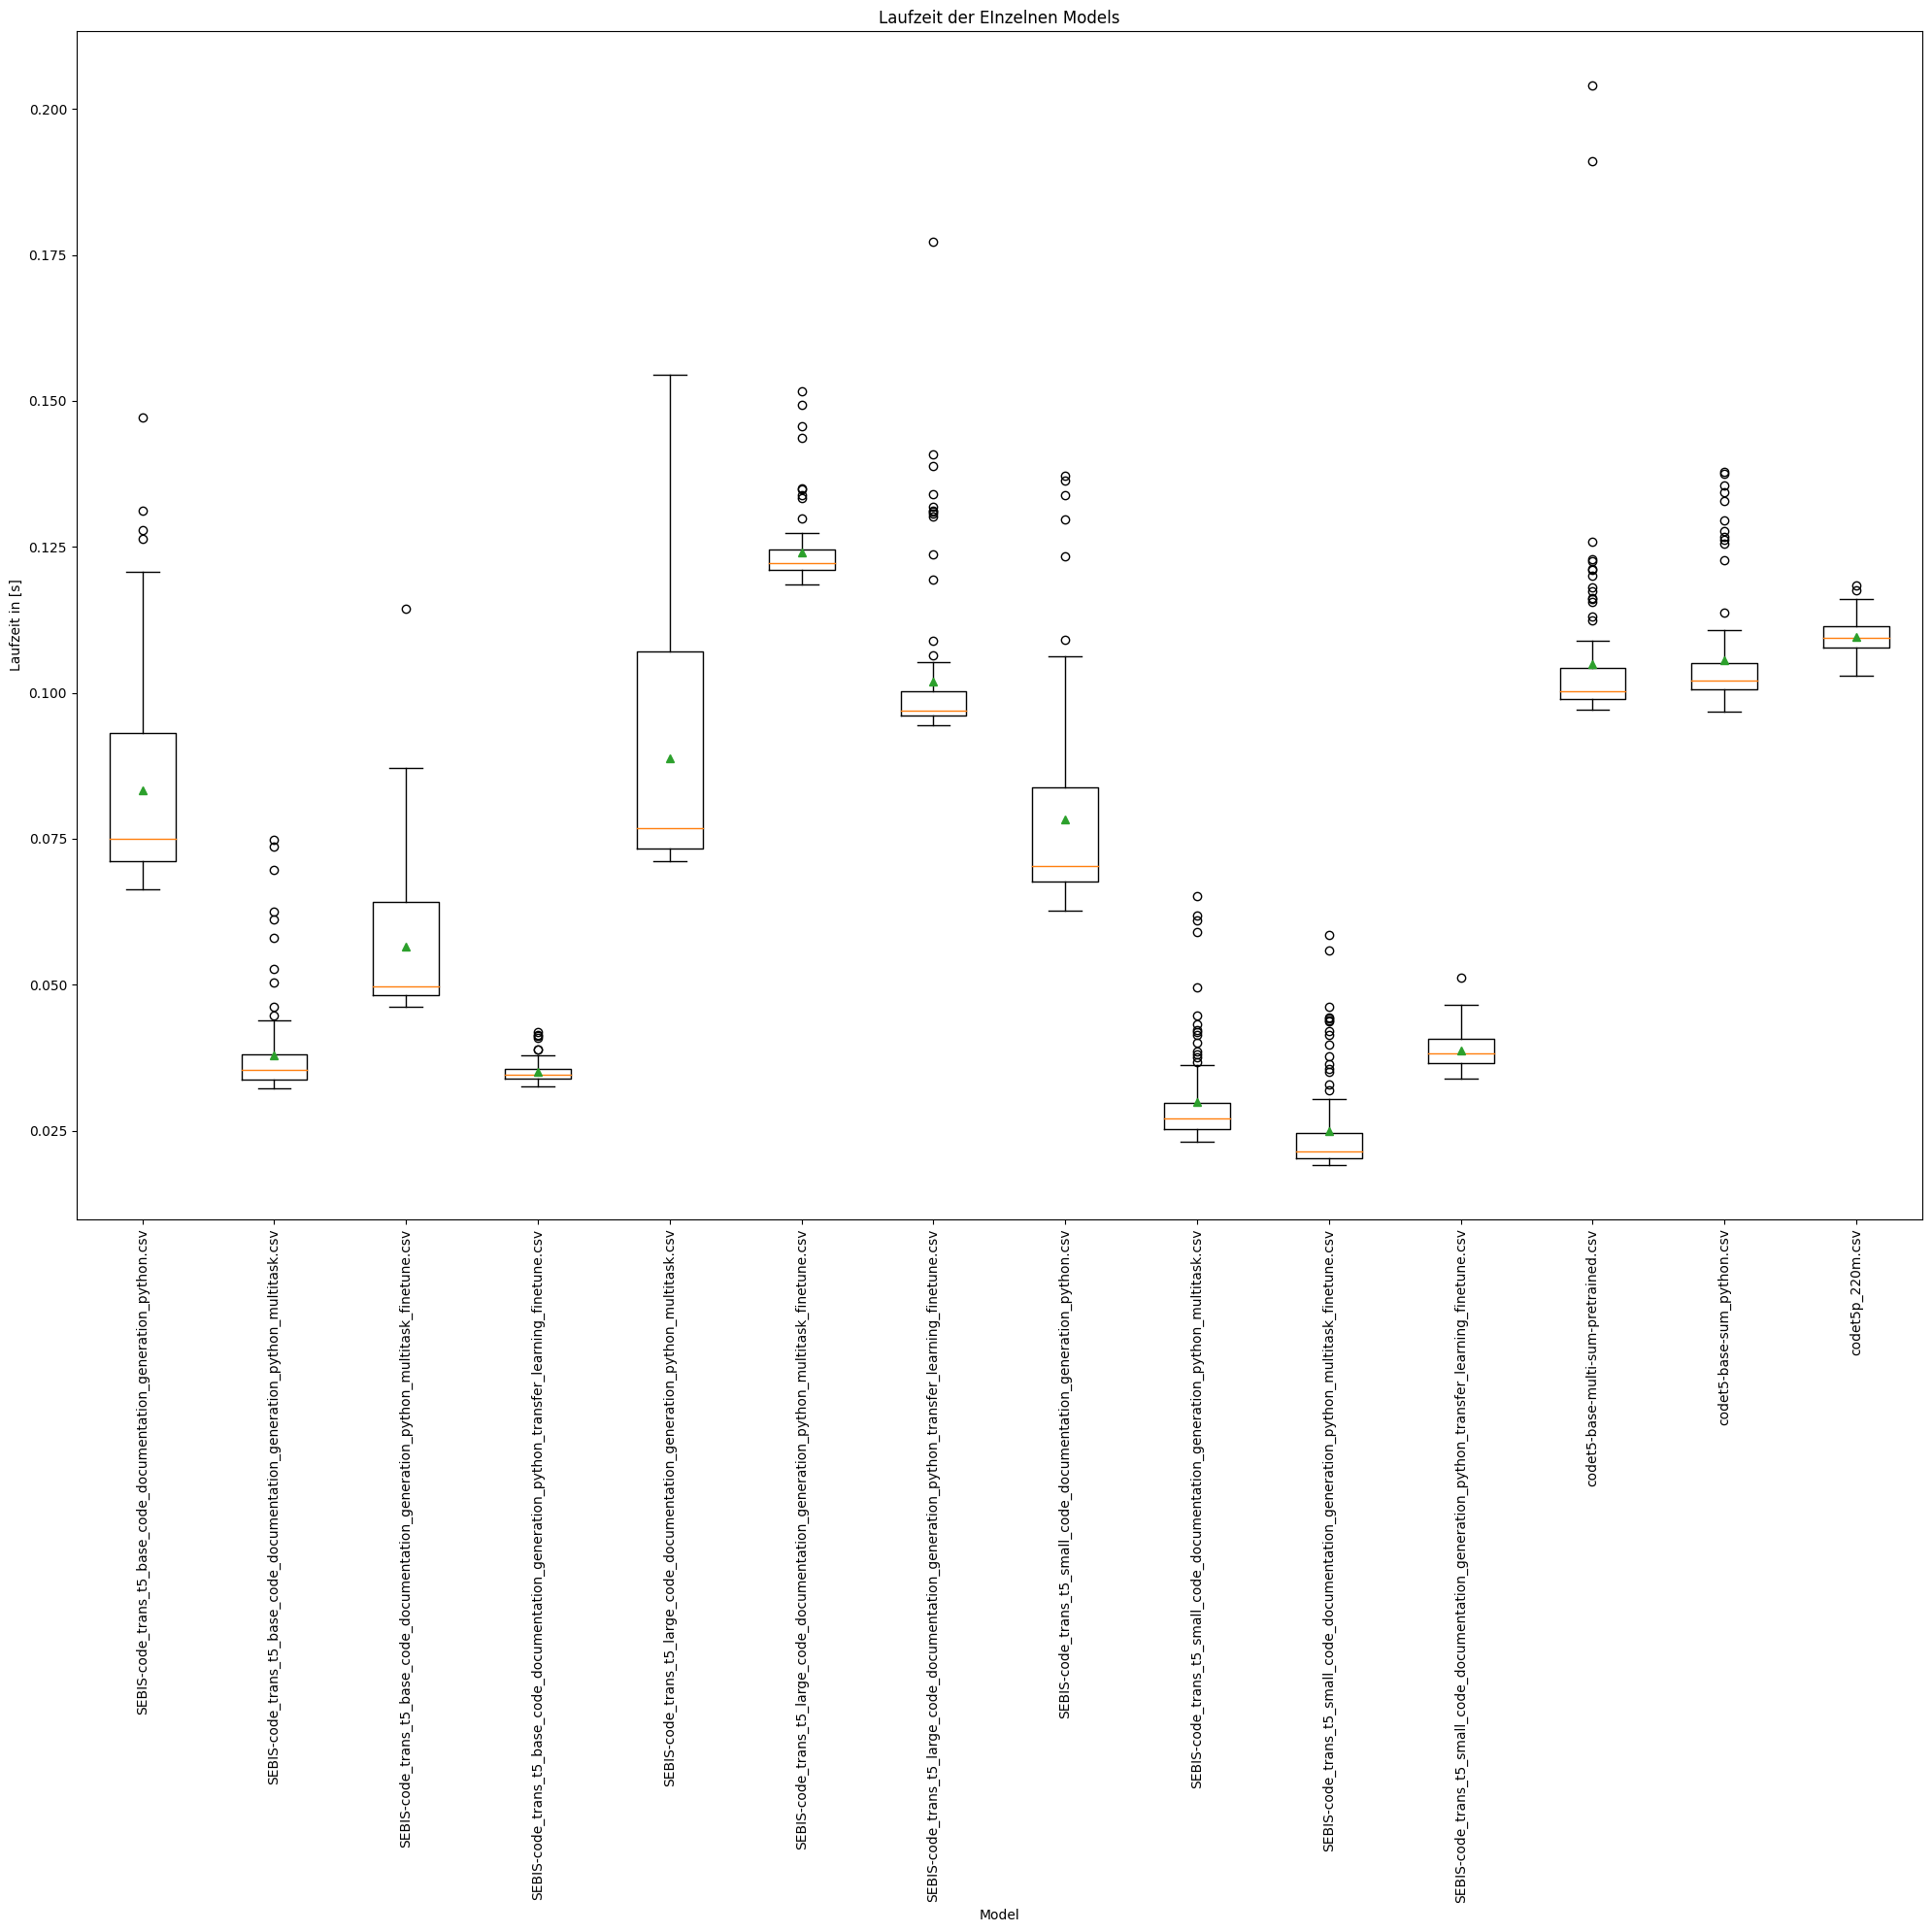

In [ ]:
fig, axes = plt.subplots(figsize=(20, 20))

data = {
    csv_file.name: pd.read_csv(csv_file, names=["runtime"])["runtime"]
    for csv_file in get_data()
}

axes.boxplot(data.values(), showmeans=True)
axes.set(
    title="Laufzeit der EInzelnen Models",
    ylabel="Laufzeit in [s]",
    xlabel="Model",
    xticklabels=data.keys(),
)
plt.xticks(rotation=90)
plt.tight_layout()

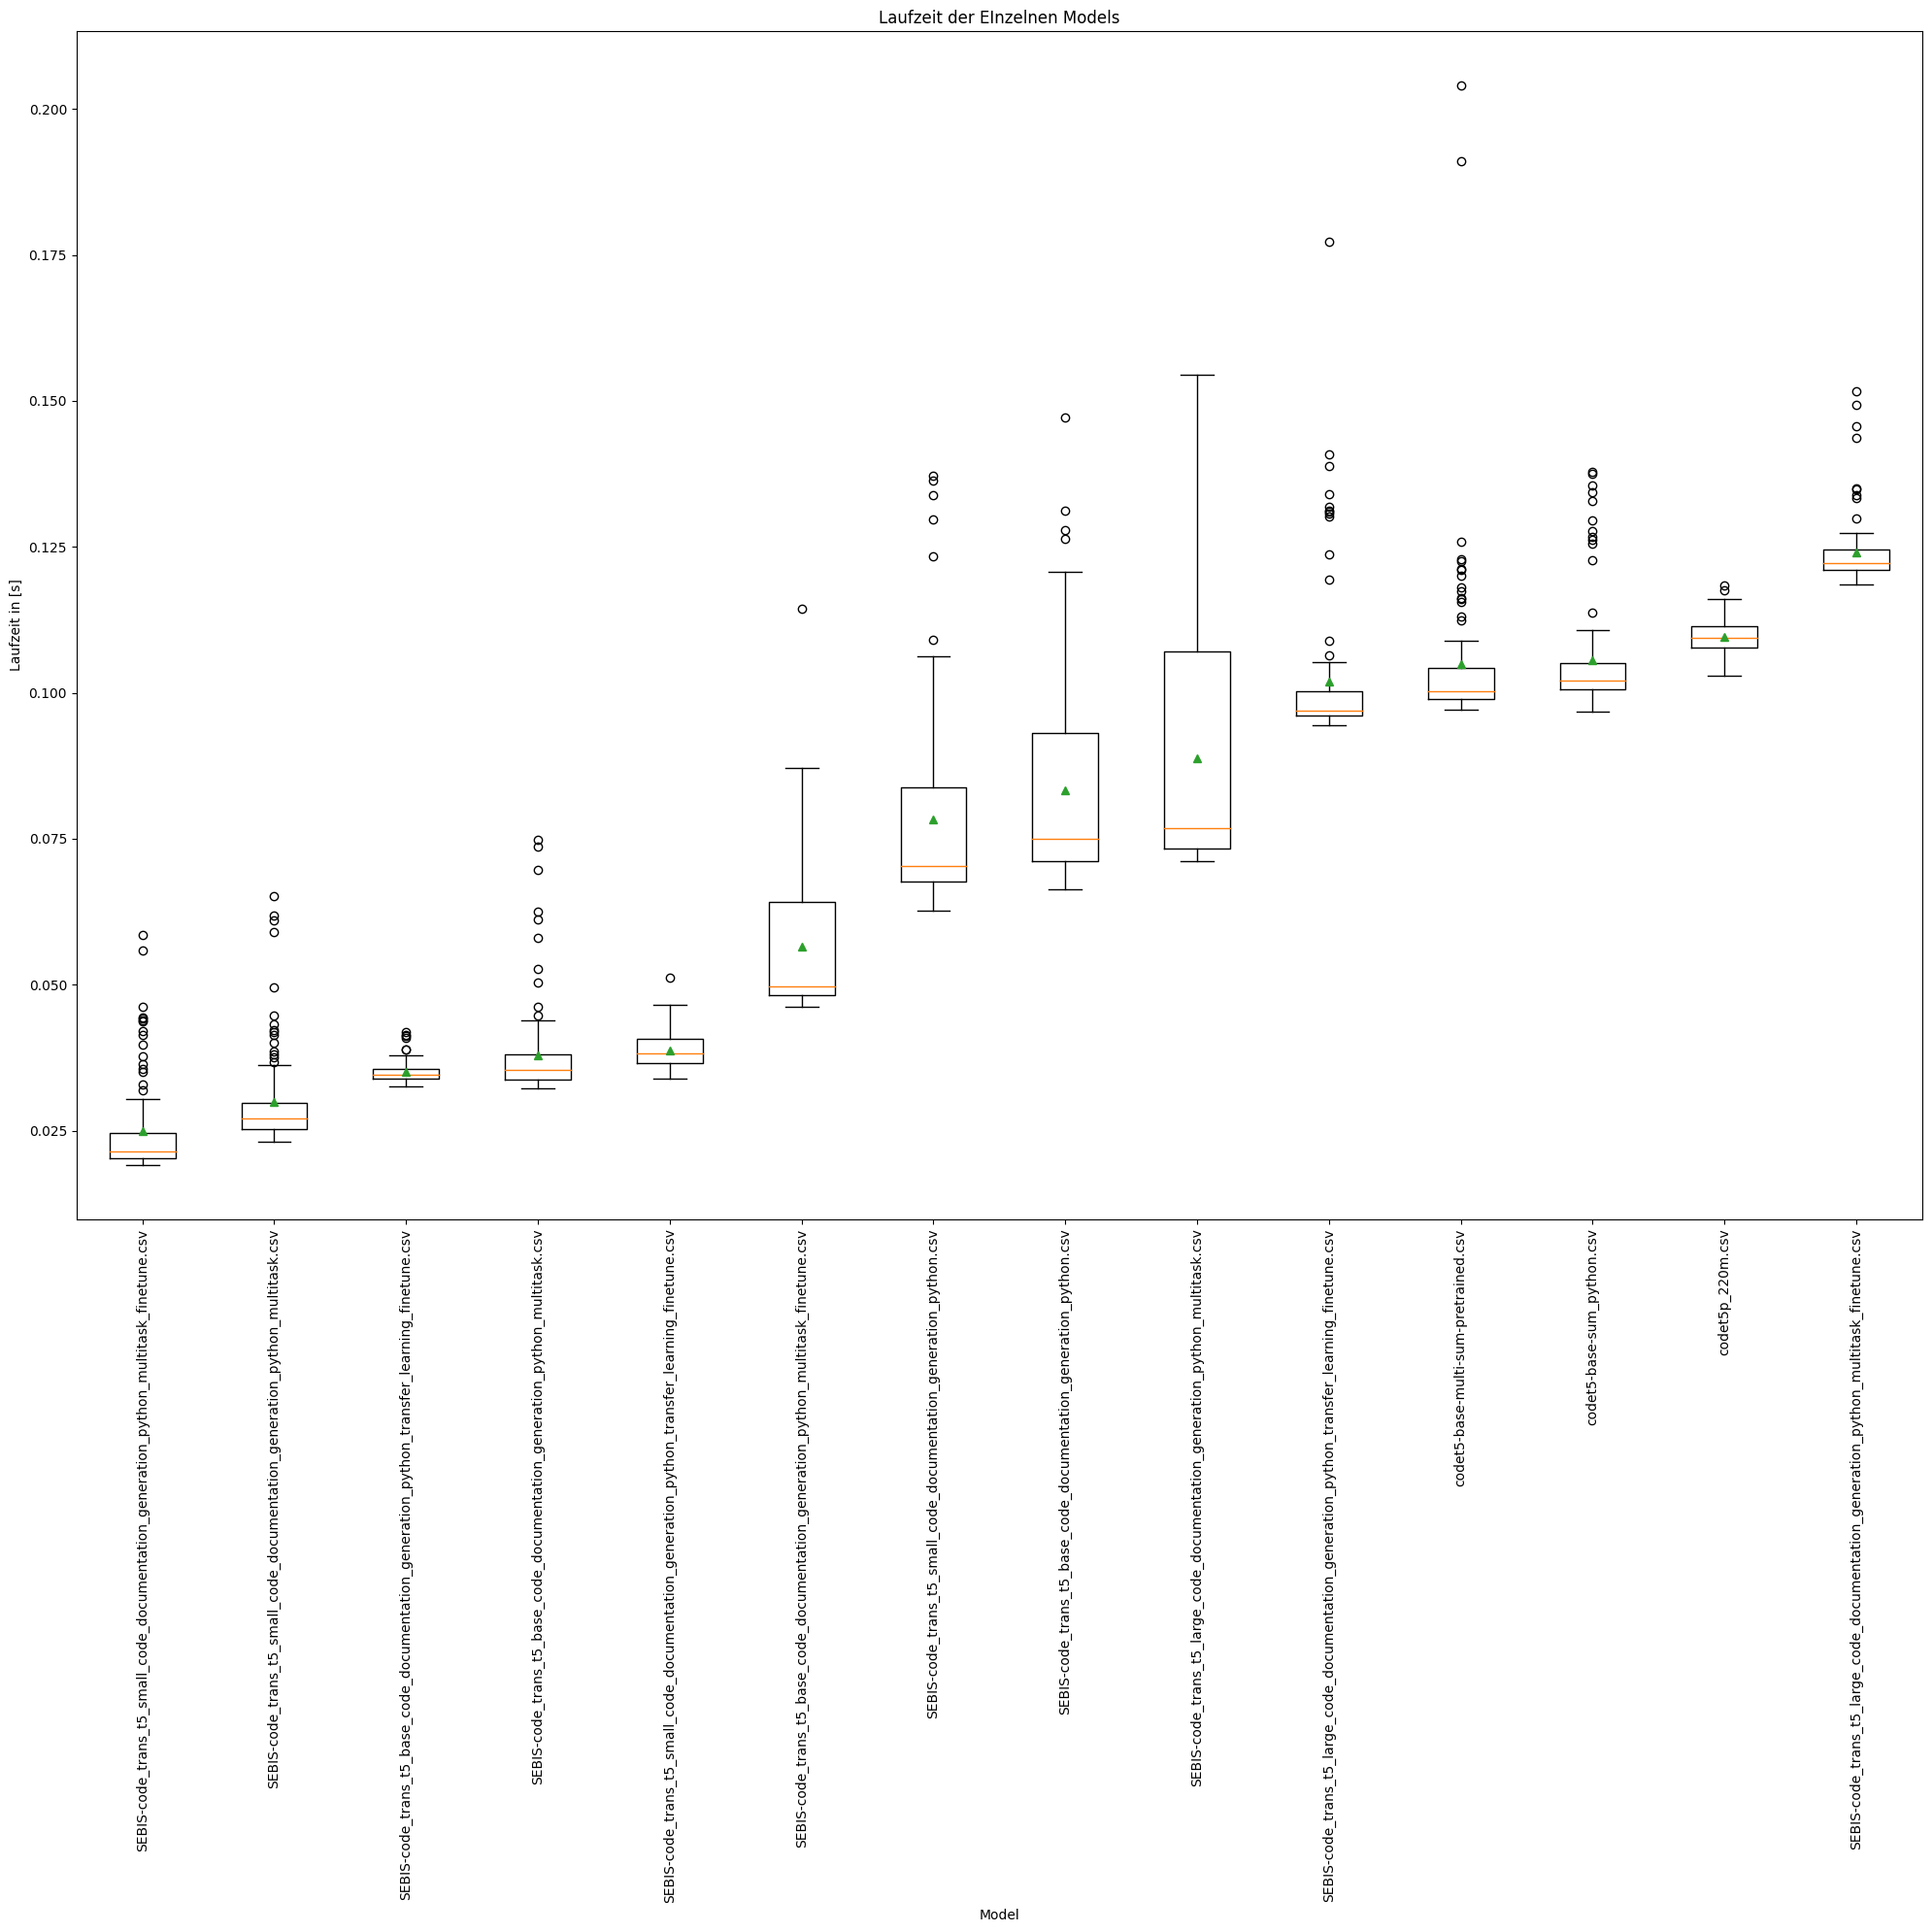

In [ ]:
fig, axes = plt.subplots(figsize=(20, 20))

data = dict(sorted({
    csv_file.name: pd.read_csv(csv_file, names=["runtime"])["runtime"]
    for csv_file in get_data()
}.items(),
key=lambda d: d[1].mean()))

axes.boxplot(data.values(), showmeans=True)
axes.set(
    title="Laufzeit der EInzelnen Models",
    ylabel="Laufzeit in [s]",
    xlabel="Model",
    xticklabels=data.keys(),
)
plt.xticks(rotation=90)
plt.tight_layout()

In [ ]:
def test_pair(sample_a: list, sample_b: list) -> None:
    """ Testet ob zwei Stichproben aus der selben Population entstammen """
    u1, p = stats.mannwhitneyu(sample_a, sample_b, method="exact")
    if p < 1e-3: # null hypothesis: values comes from the same group
        return f"The null hypothesis can be rejected (p={p})"
    return f"The null hypothesis cannot be rejected (p={p})"

In [ ]:
_data = list(data.items())
for i, (model_a, df_a) in enumerate(_data[:-1]):
    model_b, df_b = _data[i + 1]
    print(test_pair(df_a, df_b), "for", model_a, " & ", model_b)

The null hypothesis can be rejected (p=5.49643796286223e-15) for SEBIS-code_trans_t5_small_code_documentation_generation_python_multitask_finetune.csv  &  SEBIS-code_trans_t5_small_code_documentation_generation_python_multitask.csv
The null hypothesis can be rejected (p=3.144886170759452e-17) for SEBIS-code_trans_t5_small_code_documentation_generation_python_multitask.csv  &  SEBIS-code_trans_t5_base_code_documentation_generation_python_transfer_learning_finetune.csv
The null hypothesis cannot be rejected (p=0.07872397138381514) for SEBIS-code_trans_t5_base_code_documentation_generation_python_transfer_learning_finetune.csv  &  SEBIS-code_trans_t5_base_code_documentation_generation_python_multitask.csv
The null hypothesis can be rejected (p=1.2790852868754336e-07) for SEBIS-code_trans_t5_base_code_documentation_generation_python_multitask.csv  &  SEBIS-code_trans_t5_small_code_documentation_generation_python_transfer_learning_finetune.csv
The null hypothesis can be rejected (p=1.714186

In [ ]:
data = {
    csv_file.name: pd.read_csv(csv_file, names=["runtime"])["runtime"]
    for csv_file in get_data()
}
for model_name, df in data.items():
    print(model_name, f"{df.mean():.3f}", f"{df.sem():.3f}")

SEBIS-code_trans_t5_base_code_documentation_generation_python.csv 0.083 0.002
SEBIS-code_trans_t5_base_code_documentation_generation_python_multitask.csv 0.038 0.001
SEBIS-code_trans_t5_base_code_documentation_generation_python_multitask_finetune.csv 0.057 0.001
SEBIS-code_trans_t5_base_code_documentation_generation_python_transfer_learning_finetune.csv 0.035 0.000
SEBIS-code_trans_t5_large_code_documentation_generation_python_multitask.csv 0.089 0.002
SEBIS-code_trans_t5_large_code_documentation_generation_python_multitask_finetune.csv 0.124 0.001
SEBIS-code_trans_t5_large_code_documentation_generation_python_transfer_learning_finetune.csv 0.102 0.001
SEBIS-code_trans_t5_small_code_documentation_generation_python.csv 0.078 0.002
SEBIS-code_trans_t5_small_code_documentation_generation_python_multitask.csv 0.030 0.001
SEBIS-code_trans_t5_small_code_documentation_generation_python_multitask_finetune.csv 0.025 0.001
SEBIS-code_trans_t5_small_code_documentation_generation_python_transfer_l

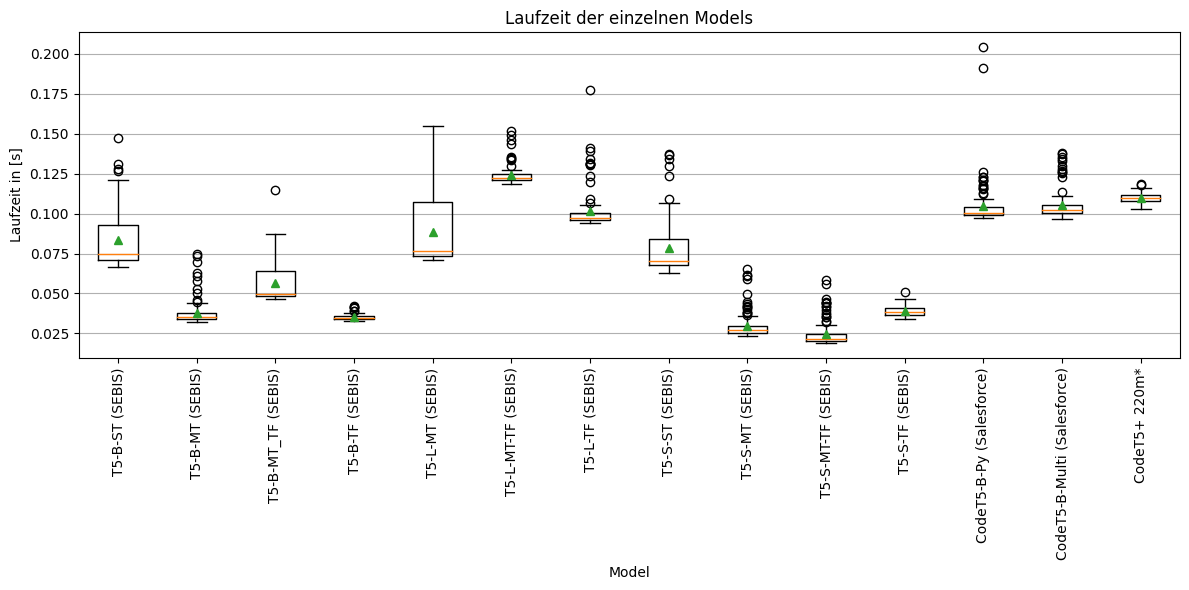

In [20]:
fig, axes = plt.subplots(figsize=(12, 6))

name_mapping = {
    "SEBIS-code_trans_t5_base_code_documentation_generation_python.csv": "T5-B-ST (SEBIS)",
    "SEBIS-code_trans_t5_base_code_documentation_generation_python_multitask.csv": "T5-B-MT (SEBIS)",
    "SEBIS-code_trans_t5_base_code_documentation_generation_python_multitask_finetune.csv": "T5-B-MT_TF (SEBIS)",
    "SEBIS-code_trans_t5_base_code_documentation_generation_python_transfer_learning_finetune.csv": "T5-B-TF (SEBIS)",
    "SEBIS-code_trans_t5_large_code_documentation_generation_python_multitask.csv": "T5-L-MT (SEBIS)",
    "SEBIS-code_trans_t5_large_code_documentation_generation_python_multitask_finetune.csv": "T5-L-MT-TF (SEBIS)",
    "SEBIS-code_trans_t5_large_code_documentation_generation_python_transfer_learning_finetune.csv": "T5-L-TF (SEBIS)",
    "SEBIS-code_trans_t5_small_code_documentation_generation_python.csv": "T5-S-ST (SEBIS)",
    "SEBIS-code_trans_t5_small_code_documentation_generation_python_multitask.csv": "T5-S-MT (SEBIS)",
    "SEBIS-code_trans_t5_small_code_documentation_generation_python_multitask_finetune.csv": "T5-S-MT-TF (SEBIS)",
    "SEBIS-code_trans_t5_small_code_documentation_generation_python_transfer_learning_finetune.csv": "T5-S-TF (SEBIS)",
    "codet5-base-multi-sum-pretrained.csv": "CodeT5-B-Py (Salesforce)",
    "codet5-base-sum_python.csv": "CodeT5-B-Multi (Salesforce)",
    "codet5p_220m.csv": "CodeT5+ 220m*"
}

data = {
    name_mapping[csv_file.name]: pd.read_csv(csv_file, names=["runtime"])["runtime"]
    for csv_file in get_data()
}

axes.boxplot(data.values(), showmeans=True)
axes.set(
    title="Laufzeit der einzelnen Models",
    ylabel="Laufzeit in [s]",
    xlabel="Model",
    xticklabels=data.keys(),
)
plt.grid(axis = 'y')
plt.xticks(rotation=90)
plt.tight_layout()